In [1]:
# --- 0. 导入所有必要的库 ---
import scirpy as ir
import scanpy as sc
import muon as mu
import pandas as pd
import os
from Bio.Align.Applications import ClustalOmegaCommandline
from Bio import AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio import Phylo
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ==============================================================================
# --- 步骤 1: 使用 Scirpy 准备数据并选择克隆 (无变化) ---
# ==============================================================================
print("--- 步骤 1: 使用 Scirpy 准备数据 ---")

mdata = ir.datasets.stephenson2021_5k()
ir.tl.chain_qc(mdata)
ir.pp.ir_dist(mdata, metric="normalized_hamming", sequence="nt")
ir.tl.define_clonotype_clusters(
    mdata,
    sequence="nt",
    metric="normalized_hamming",
    receptor_arms="all",
    dual_ir="any",
    same_v_gene=True,
    key_added="clone_id_85_similarity",
)
largest_clone_id = mdata.obs["airr:clone_id_85_similarity"].value_counts().index[0]
n_cells_in_clone = mdata.obs["airr:clone_id_85_similarity"].value_counts().iloc[0]
print(f"\nScirpy 分析完成。最大的克隆 ID 为: '{largest_clone_id}' ({n_cells_in_clone} 个细胞)。")
mdata_clone = mdata[mdata.obs["airr:clone_id_85_similarity"] == largest_clone_id, :].copy()
adata_airr_clone = mdata_clone.mod['airr']

/home/wqzhao/anaconda3/lib/python3.11/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


--- 步骤 1: 使用 Scirpy 准备数据 ---


/home/wqzhao/anaconda3/lib/python3.11/site-packages/anndata/utils.py:354: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)
/home/wqzhao/anaconda3/lib/python3.11/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/wqzhao/anaconda3/lib/python3.11/site-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will b


Scirpy 分析完成。最大的克隆 ID 为: '9' (17 个细胞)。


/home/wqzhao/anaconda3/lib/python3.11/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/wqzhao/anaconda3/lib/python3.11/site-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [2]:
# ==============================================================================
# --- 步骤 2: 提取序列并创建 FASTA 文件 (最终修正版) ---
# ==============================================================================
print("\n--- 步骤 2: 提取序列并创建 FASTA 文件 ---")

fasta_filename = "clone_sequences.fasta"
cell_sequences = {}

# 获取 AIRR 数据和细胞 ID 列表
airr_data = adata_airr_clone.obsm["airr"]
cell_ids = adata_airr_clone.obs.index

# 按细胞索引进行迭代
for i in range(len(adata_airr_clone)):
    # 1. 从 .obs.index 获取细胞ID
    cell_id = cell_ids[i]
    
    # 2. 获取该细胞对应的所有链记录
    record_for_cell = airr_data[i]
    
    # 3. 在该细胞的链记录中，找到重链(IGH)
    is_igh_in_record = (record_for_cell['locus'] == 'IGH')
    
    # 4. 提取所有重链的序列
    igh_sequences_for_cell = record_for_cell['sequence'][is_igh_in_record]
    
    # 5. 如果找到了重链序列，就取第一条并存储
    if len(igh_sequences_for_cell) > 0:
        # 我们只取找到的第一条重链序列
        sequence = igh_sequences_for_cell[0]
        cell_sequences[cell_id] = sequence

# 将序列写入 FASTA 文件
with open(fasta_filename, "w") as f:
    for cell_id, sequence in cell_sequences.items():
        f.write(f">{cell_id}\n")
        f.write(f"{sequence}\n")

print(f"成功将 {len(cell_sequences)} 条序列写入到文件 '{fasta_filename}'")


--- 步骤 2: 提取序列并创建 FASTA 文件 ---
成功将 17 条序列写入到文件 'clone_sequences.fasta'



--- 步骤 3: 使用 BioPython 进行比对和建树 ---
正在调用 ClustalOmega 进行多重序列比对...


多重序列比对完成。
正在计算距离矩阵...
正在使用邻接法构建树...

--- 步骤 4: 可视化简化的系统发育树 ---


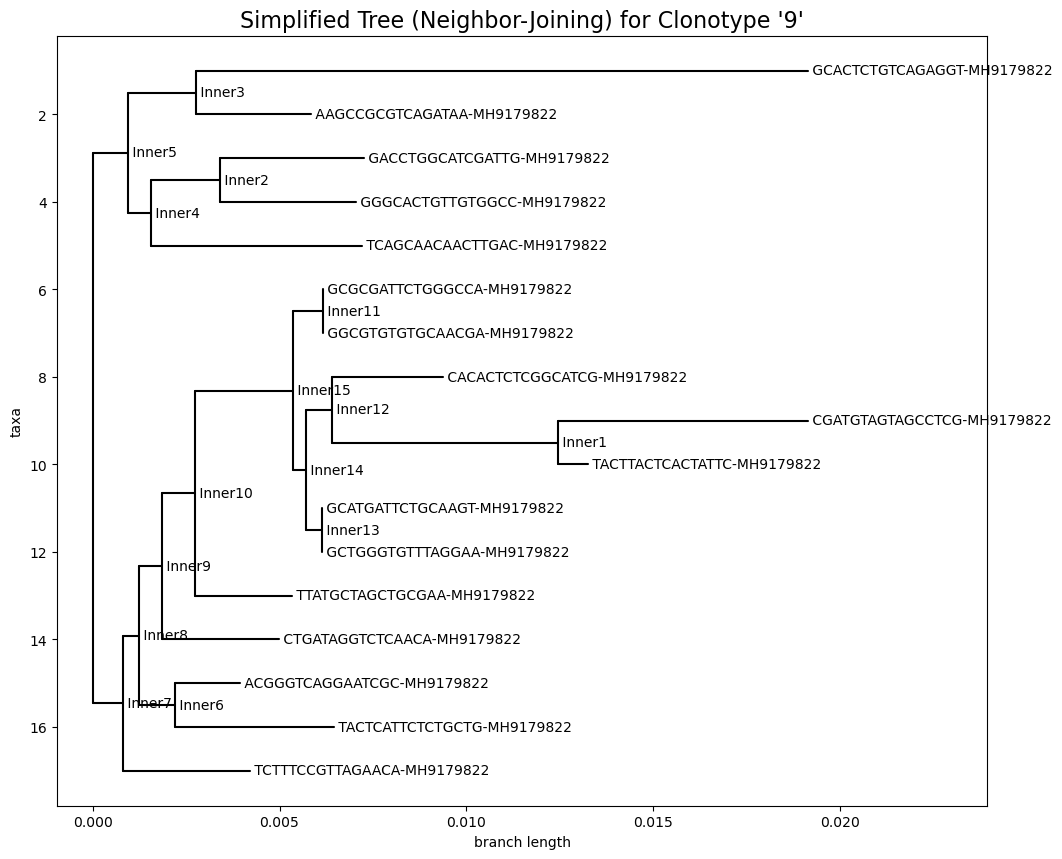

系统发育树绘制完成！


In [3]:
# ==============================================================================
# --- 步骤 3 & 4: 比对、建树与可视化 (无变化) ---
# ==============================================================================
print("\n--- 步骤 3: 使用 BioPython 进行比对和建树 ---")
aligned_fasta_filename = "clone_sequences_aligned.fasta"
tree_construction_success = False

try:
    print("正在调用 ClustalOmega 进行多重序列比对...")
    cline = ClustalOmegaCommandline(
        infile=fasta_filename, outfile=aligned_fasta_filename,
        verbose=True, auto=True, force=True
    )
    stdout, stderr = cline()
    print("多重序列比对完成。")

    print("正在计算距离矩阵...")
    with open(aligned_fasta_filename, "r") as handle:
        aln = AlignIO.read(handle, "fasta")
    
    calculator = DistanceCalculator('identity')
    distance_matrix = calculator.get_distance(aln)

    print("正在使用邻接法构建树...")
    constructor = DistanceTreeConstructor(calculator, 'nj')
    tree = constructor.build_tree(aln)
    tree.root_at_midpoint()
    
    tree_construction_success = True

except FileNotFoundError:
    print("\n错误: 'clustalo' 命令未找到。")
    print("请先通过 'conda install -c bioconda clustalo' 安装。")
except Exception as e:
    print(f"\n在比对或建树过程中发生错误: {e}")

if tree_construction_success:
    print("\n--- 步骤 4: 可视化简化的系统发育树 ---")
    fig, ax = plt.subplots(figsize=(12, 10))
    Phylo.draw(tree, axes=ax, do_show=False)
    ax.set_title(f"Simplified Tree (Neighbor-Joining) for Clonotype '{largest_clone_id}'", fontsize=16)
    plt.show()
    print("系统发育树绘制完成！")
else:
    print("\n由于比对或建树步骤失败，跳过可视化。")